## Importing Packages

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import scipy.stats as ss
import seaborn as sns
import math
import reliability as rel
import itertools

## Data

In [2]:
filepath = 'data/adaptor.mars.internal-1672143264.6032207-29456-16-ff921cab-c117-4bb5-905f-6f1e258ecc2d.nc'
ds = xr.open_dataset(filepath)

In [3]:
lat = ds.u100.latitude.data
lon = ds.u100.longitude.data
time = ds.u100.time.data
speed = ds.u100.data

In [4]:
ds.u100.dims

('time', 'latitude', 'longitude')

## Functions

In [5]:

'''plots a color mesh on a given axis. Needa a label param as a dict'''
def pcolormesh_plotter(ax, data1, params):
    ax.set_title(params['label'])
    out = ax.pcolormesh(lon, lat, data1, shading='auto', **params)
    return out

'''Converts u and v velocities for given lat, lon to list of speeds. Done for all time vales'''
def get_speed(lat, lon):
    
    u_data = ds.u100.sel(latitude=lat, longitude=lon)
    v_data = ds.v100.sel(latitude=lat, longitude=lon)
    
    #define array for position 1
    datalist = []

    #loop to find the resultant speed for every entry of u100 and v100
    for i in range(len(u_data.data)):
        datalist.append(math.sqrt((u_data.data[i]**2)+(v_data.data[i]**2)))

    #converting to numpy array with more compact float32
    #np.array(datalist, dtype='float32')
    
    print('done {}, {}'.format(lat,lon))
    
    return datalist

def f_weibull(x, beta, alpha):
    return (beta/alpha)*((x/alpha)**(beta-1))*math.exp(-(x/alpha)**beta)

'''adding weibull inverse function'''
def weibull_inv(p):
    return np.log(-np.log(1.0-p))


In [6]:
#wb = rel.Fitters.Fit_Weibull_2P(failures=mydata)


## Procedure

Contents:
1. Creating datasets
2. Parametrizing data

### 1. Creating total dataset

In [7]:
len_lats = len(ds.u100.latitude.data)
len_lons = len(ds.u100.longitude.data)

In [8]:
u_flat = np.array(ds.u100.data).flatten()
v_flat = np.array(ds.v100.data).flatten()

In [9]:
qspeed = [math.sqrt(i**2+j**2) for i,j in zip(u_flat, v_flat)]

Text(23, 0.135, '$\\sigma=5.77$\n$max=28.03$\n$median=5.28$')

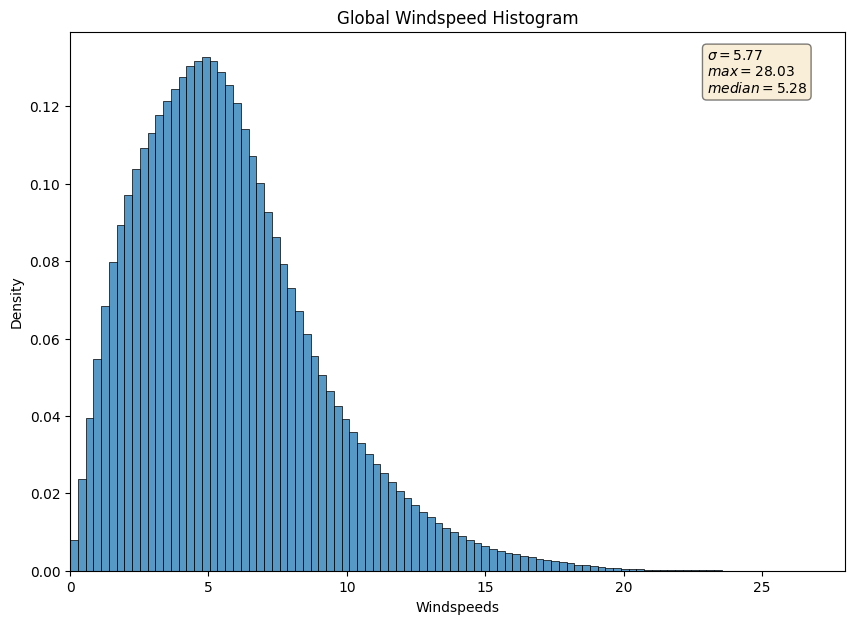

In [267]:
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.histplot(qspeed, bins = 100, stat='density')
ax.set_title('Global Windspeed Histogram')
ax.set_xlabel('Windspeeds')
ax.set_xlim(0,28)

# text box
textstr = '\n'.join((
    r'$\sigma=%.2f$' % (np.mean(qspeed), ),
    r'$max=%.2f$' % (max(qspeed), ),
    r'$median=%.2f$' % (np.median(qspeed), )))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
plt.text(23, 0.135, textstr, fontsize=10, verticalalignment='top', bbox=props)

In [11]:
print('The max is:',max(qspeed))
print('The mean is:',np.mean(qspeed))
print('The median is:',np.median(qspeed))

The max is: 28.032866156014727
The mean is: 5.765797627964828
The median is: 5.283123468812585


Note: since the maximum wind speed is approximately 28 m/s we discretize our speed domain from 0 to 28 for future calculations

### Parametrizing Data

In this section we use the reliability module and the scipy.stats module to fit our data to a weibul curve. 

the reliability module finds shape and scale parameters (alpha, beta) for a given distribution

in scipy.stats we use weibull_min and exponweibull functions for 2-parameter and 3-parameter fittings respectively

#### Using reliability to find shape and scale parameters

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 12640680/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         6.49391      0.00105806   6.49183   6.49598
     Beta         1.81998     0.000392414   1.81921   1.82075 

Goodness of fit        Value
 Log-likelihood -3.19344e+07
           AICc  6.38689e+07
            BIC  6.38689e+07
             AD       7000.2 



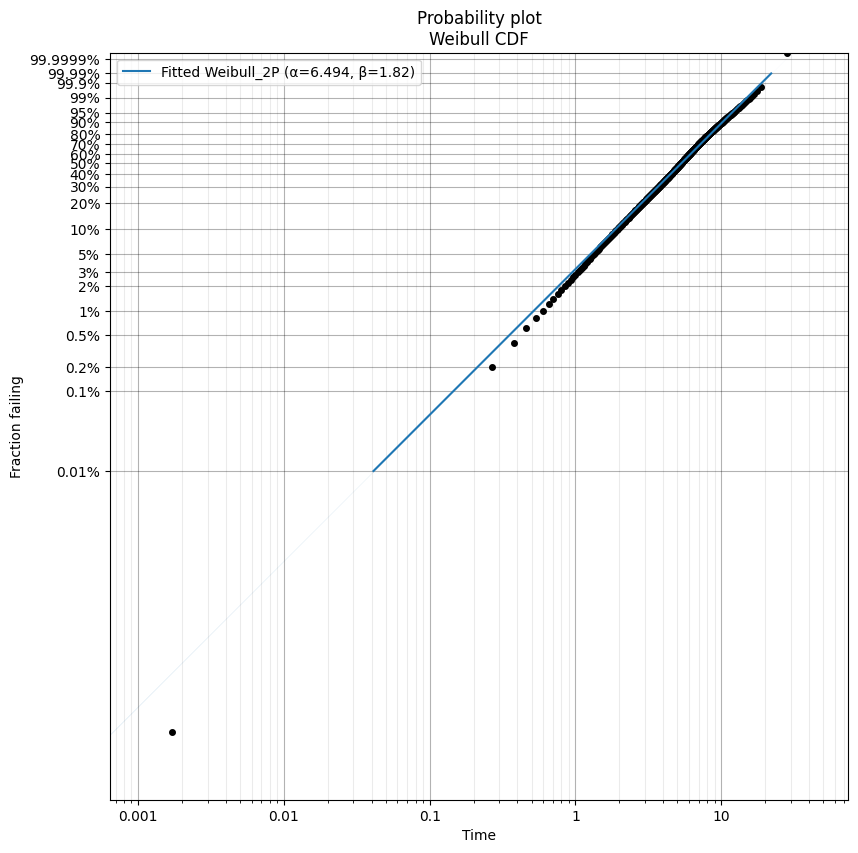

In [13]:
wb = rel.Fitters.Fit_Weibull_2P(failures=qspeed)

note: 
beta = shape = (c)
alpha = scale = (scale)

#### Checking with SciPy exponweib.fit

Since scipy provides weibull_min ([scipy.weibull_min()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.weibull_min.html#scipy.stats.weibull_min)) and exponential-weibull fitting ([scipy.exponweib()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.exponweib.html))

First we parametrize using the standard weibull function

In [14]:
#params = ss.exponweib.fit(data=qspeed, floc=0, 
#                           f0=1)
params = ss.weibull_min.fit(data=qspeed, floc=0)
params

(1.8199774943600948, 0, 6.493899889444551)

these are within reasonable closeness to the answers obtained from 'reliability' module (1.82, 6.494)

Let us also try to see what parametrization we get when we use exponential weibull parametrization i.e. when we do not fix the exponentiation parameter (a)

In [15]:
params2 = ss.exponweib.fit(data=qspeed, floc=0)
params2

(1.3400541018817773, 1.5554382945073915, 0, 5.575974379170869)

Since these values are different, lets assign these parameters and compare them to the general, 2 parameter weibull curve

In [16]:
a, c, loc, scale = [params2[i] for i in range(4)]
rv=ss.exponweib(a,c, loc, scale)

#### Comparing the fitting of 2-parameter and exponentiated weibulls

Assigning general values and creating the pdf of the 2 parameter weibull

In [17]:
bin_count=100
#we sample bin_count number of times from a space of (0,28)
tries = np.linspace(0,28,bin_count)
beta = 1.82
alpha = 6.494
glob_pdf = [f_weibull(i, beta, alpha) for i in tries]

Now lets plot the two curves vs the histogram to visually compare fits

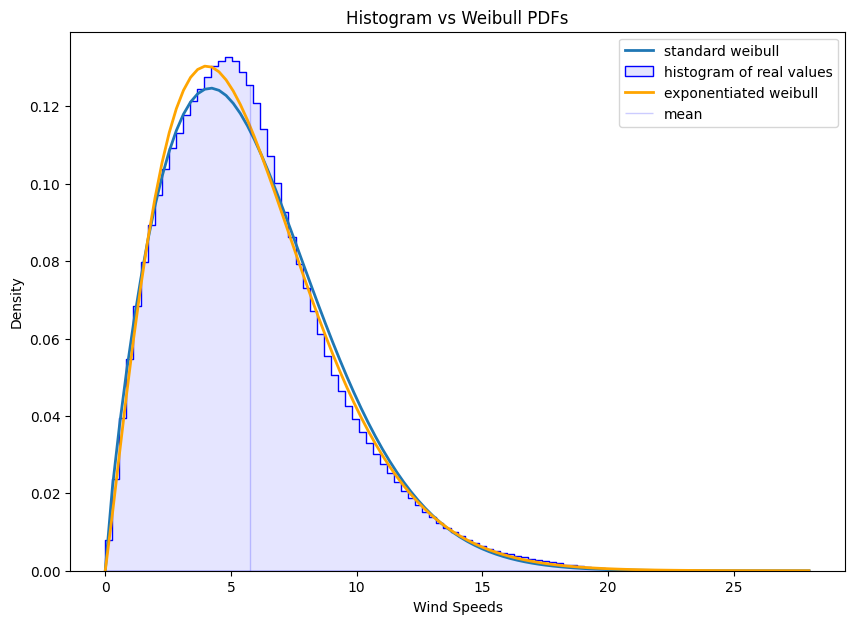

In [256]:
fix, ax = plt.subplots(1,1, figsize=(10,7))

ax.set_title('Histogram vs Weibull PDFs')


d1, = ax.plot(tries, glob_pdf, linewidth='2', alpha=1, label='standard weibull')
d2 = sns.histplot(qspeed, bins = bin_count, stat='density', element='step', alpha=0.1, label='histogram of real values', color='b')
d3, = ax.plot(tries, rv.pdf(tries), color='orange', linewidth='2', alpha=1, label='exponentiated weibull')
d4 = plt.vlines(np.mean(qspeed), ymin=0, ymax=0.1255, linewidth=1, alpha=0.2, color='blue', label='mean')

ax.set_xlabel('Wind Speeds')

ax.legend()

At first glance the exponentiated weibull seems to fit better

#### Error Calculations

histogram implementation from [numpy.histogram()](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html)

In [47]:
weights, bins = np.histogram(qspeed, bins = bin_count, range = (0,28), density=True)

In [48]:
errors = [i-j for i,j in zip(glob_pdf,weights)]
percent_errors = [i/100 for i in errors]
abs_errors = [abs(i-j) for i,j in zip(glob_pdf,weights)]

errors2 = [i-j for i,j in zip(rv.pdf(tries), weights)]
percent_errors2 = [i/100 for i in errors2]
abs_errors2 = [abs(i-j) for i,j in zip(rv.pdf(tries),weights)]

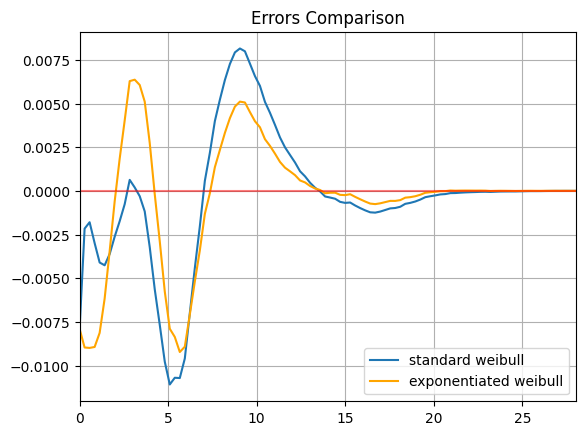

In [49]:
fig, ax = plt.subplots()

ax.set_title('Errors Comparison')
ax.grid()

l1 = ax.plot(tries, errors, label='standard weibull')
l2 = ax.plot(tries, errors2, color='orange', label='exponentiated weibull')
ax.plot(tries, [0]*bin_count, color='red', alpha=0.5)

ax.set_xlim(0,28)
ax.legend(loc='lower right')

In [50]:
print('Standard Weibull error: ',int(10000*sum(abs_errors))/10000)
print('Exponentiated Weibull error: ',int(10000*sum(abs_errors2))/10000)

Standard Weibull error:  0.2293
Exponentiated Weibull error:  0.2071


We compare the errors by calculating the areas between the respective error curves

In [51]:
binwidth = bins[3]-bins[2]
area1 = sum([i*binwidth for i in abs_errors])
area2 = sum([i*binwidth for i in abs_errors2])
print('Percent diff wrt standard weibull=', int(10000*abs(area1-area2)/area1*100)/10000,'%')

Percent diff wrt standard weibull= 9.6709 %


this is almost a 10% difference in area!

### Comparing with Individual curves

Now we try to parametrize how far the curves for individual areas compare to the parametrization of the complete windspeed curve

Creating a dataframe for error values

In [52]:
lats_list = np.arange(47,56.25,0.25)
lons_list = np.arange(6,15.75,0.25)

df_errors = pd.DataFrame(columns=lats_list, index=lons_list)

In [53]:
def calculate_errors(lat, lon, bin_count):
    
    #create speeds list
    u_data = ds.u100.sel(latitude=lat, longitude=lon)
    v_data = ds.v100.sel(latitude=lat, longitude=lon)
    speeds = [math.sqrt(i**2+j**2) for i,j in zip(u_data, v_data)]
    
    #print('done speed list')
    
    #get histogram weights
    w,b = np.histogram(speeds,bin_count, range=(0,28), density=True)
    
    #print('done weights list')
    
    #get weibull parameters
    beta, nope, alpha = ss.weibull_min.fit(data=speeds, floc=0)
    
    #print('done parameters')
    
    #sample weibull pdf for values
    tries = np.linspace(0,28, bin_count)
    pdf = [f_weibull(i, beta, alpha) for i in tries]
    
    #print('done pdf list')
    
    #calculate errors
    errors = [i-j for i,j in zip(pdf,weights)]
    
    #print('done error list')
    
    return errors
    

In [ ]:
for i in lats_list:
    print('doing: ',i)
    for j in lons_list:
        df_errors[i][j] = calculate_errors(i,j, bin_count)

In [ ]:
lon_short = np.arange(6,16,1)
lat_short = np.arange(47,57,1)

In [ ]:
df_err_short = pd.DataFrame(columns=lat_short, index=lon_short)

In [ ]:
print([i for i in df_err_short.index])

for i in df_err_short.columns:
    print('doing', i)
    print('______________')
    for j in df_err_short.index:
        print('doing', j)
        df_err_short[i][j] = calculate_errors(i,j, bin_count)
        


In [ ]:
df_err_short

In [ ]:
# Saving as a CSV
'''df_err_short.to_csv('df_err_short.csv', encoding='utf-8')'''
#To read the saved CSV
'''df_test = pd.read_csv('df_err_short.csv', index_col=[0])''' #index_col arg identifies which column should be used as the index

graphing the errors as above

In [ ]:
fig, ax = plt.subplots()

ax.set_title('Errors Comparison')
ax.grid()

for i in df_err_short.columns:
    for j in df_err_short.index:
        errors = df_err_short[i][j]
        ax.plot(tries, errors, color='orange', alpha=0.2)

l0 = ax.plot(tries, df_err_short[50][6], color='orange', alpha=0.2, label='individual errors')
l1 = ax.plot(tries, errors, label='total error curve') #total curve

ax.set_xlim(0,28)
ax.legend(loc='lower right')

Note: This comparison is between the errors of the global parametrization to its actual histogram and the errors of local parametrizations to the global histogram. i.e. senseless! We need to compare the global pdf with the local pdfs!!

Trying to get the brackets of error in each bin

In [ ]:
#defining ranges dataframe
df_err_short_ranges = pd.DataFrame(columns=['ranges'], index=np.arange(0,100,1))

In [ ]:
for n in range(100):    
    mid_range = []
    for i in df_err_short.columns:
        for j in df_err_short.index:
            #first_range = first_range + df_err_short[i][j][0]
            mid_range.append(df_err_short[i][j][n])
            df_err_short_ranges['ranges'][n] = mid_range

In [ ]:
for n in df_err_short_ranges.index:
    range_max = max(df_err_short_ranges['ranges'][n])
    range_min = min(df_err_short_ranges['ranges'][n])
    range_mean = sum(df_err_short_ranges['ranges'][n])/len(df_err_short_ranges['ranges'][n])
    
    df_err_short_ranges['max'][n] = range_max
    df_err_short_ranges['min'][n] = range_min
    df_err_short_ranges['mean'][n] = range_mean

In [ ]:
df_err_short_ranges['width'] = abs(df_err_short_ranges['max']-df_err_short_ranges['min'])

In [ ]:
df_err_short_ranges

In [ ]:
fig, ax = plt.subplots()

#l2 = plt.vlines(x = tries[1], ymin=df_err_short_ranges['min'][5], ymax=df_err_short_ranges['max'][5], linewidth=10, alpha=0.1, color='b')
l1 = ax.plot(tries, errors, label='total error curve') #total curve
l0 = ax.plot(tries, df_err_short_ranges['mean'], color='orange', alpha=1, label='mean of errors')
ax.set_xlim(0,28)
for i in range(100):
    plt.vlines(tries[i], ymin=df_err_short_ranges['min'][i], ymax=df_err_short_ranges['max'][i], linewidth=3, alpha=0.15, color='orange')
    ax.set_xlim(0,28)
ax.legend(loc='lower right')

Now we first make a dataframe of the speeds, then the weibull parameters

In [54]:
df_speeds_short = pd.DataFrame(columns=lat_short, index=lon_short)
df_params_short = pd.DataFrame(columns=lat_short, index=lon_short)

NameError: name 'lat_short' is not defined

In [55]:
df_speeds = pd.DataFrame(columns=lats_list, index=lons_list)
df_params = pd.DataFrame(columns=lats_list, index=lons_list)

First we calculate the windspeeds DataFrame

In [56]:
def calc_speed(lat,lon):
    
    u_data = ds.u100.sel(latitude=lat, longitude=lon).data
    v_data = ds.v100.sel(latitude=lat, longitude=lon).data
    speeds_list = [math.sqrt(i**2+j**2) for i,j in zip(u_data, v_data)]
    #print('done',i,j)
    return speeds_list

In [59]:
for i in df_speeds.columns:
    print('doing',i)
    for j in df_speeds.index:
        df_speeds[i][j] = calc_speed(i,j)

done 47.0 6.0
done 47.0 6.25
done 47.0 6.5
done 47.0 6.75
done 47.0 7.0
done 47.0 7.25
done 47.0 7.5
done 47.0 7.75
done 47.0 8.0
done 47.0 8.25
done 47.0 8.5
done 47.0 8.75
done 47.0 9.0
done 47.0 9.25
done 47.0 9.5
done 47.0 9.75
done 47.0 10.0
done 47.0 10.25
done 47.0 10.5
done 47.0 10.75
done 47.0 11.0
done 47.0 11.25
done 47.0 11.5
done 47.0 11.75
done 47.0 12.0
done 47.0 12.25
done 47.0 12.5
done 47.0 12.75
done 47.0 13.0
done 47.0 13.25
done 47.0 13.5
done 47.0 13.75
done 47.0 14.0
done 47.0 14.25
done 47.0 14.5
done 47.0 14.75
done 47.0 15.0
done 47.0 15.25
done 47.0 15.5
done 47.25 6.0
done 47.25 6.25
done 47.25 6.5
done 47.25 6.75
done 47.25 7.0
done 47.25 7.25
done 47.25 7.5
done 47.25 7.75
done 47.25 8.0
done 47.25 8.25
done 47.25 8.5
done 47.25 8.75
done 47.25 9.0
done 47.25 9.25
done 47.25 9.5
done 47.25 9.75
done 47.25 10.0
done 47.25 10.25
done 47.25 10.5
done 47.25 10.75
done 47.25 11.0
done 47.25 11.25
done 47.25 11.5
done 47.25 11.75
done 47.25 12.0
done 47.25 12.25

done 50.25 13.25
done 50.25 13.5
done 50.25 13.75
done 50.25 14.0
done 50.25 14.25
done 50.25 14.5
done 50.25 14.75
done 50.25 15.0
done 50.25 15.25
done 50.25 15.5
done 50.5 6.0
done 50.5 6.25
done 50.5 6.5
done 50.5 6.75
done 50.5 7.0
done 50.5 7.25
done 50.5 7.5
done 50.5 7.75
done 50.5 8.0
done 50.5 8.25
done 50.5 8.5
done 50.5 8.75
done 50.5 9.0
done 50.5 9.25
done 50.5 9.5
done 50.5 9.75
done 50.5 10.0
done 50.5 10.25
done 50.5 10.5
done 50.5 10.75
done 50.5 11.0
done 50.5 11.25
done 50.5 11.5
done 50.5 11.75
done 50.5 12.0
done 50.5 12.25
done 50.5 12.5
done 50.5 12.75
done 50.5 13.0
done 50.5 13.25
done 50.5 13.5
done 50.5 13.75
done 50.5 14.0
done 50.5 14.25
done 50.5 14.5
done 50.5 14.75
done 50.5 15.0
done 50.5 15.25
done 50.5 15.5
done 50.75 6.0
done 50.75 6.25
done 50.75 6.5
done 50.75 6.75
done 50.75 7.0
done 50.75 7.25
done 50.75 7.5
done 50.75 7.75
done 50.75 8.0
done 50.75 8.25
done 50.75 8.5
done 50.75 8.75
done 50.75 9.0
done 50.75 9.25
done 50.75 9.5
done 50.75 9.75

done 53.75 8.5
done 53.75 8.75
done 53.75 9.0
done 53.75 9.25
done 53.75 9.5
done 53.75 9.75
done 53.75 10.0
done 53.75 10.25
done 53.75 10.5
done 53.75 10.75
done 53.75 11.0
done 53.75 11.25
done 53.75 11.5
done 53.75 11.75
done 53.75 12.0
done 53.75 12.25
done 53.75 12.5
done 53.75 12.75
done 53.75 13.0
done 53.75 13.25
done 53.75 13.5
done 53.75 13.75
done 53.75 14.0
done 53.75 14.25
done 53.75 14.5
done 53.75 14.75
done 53.75 15.0
done 53.75 15.25
done 53.75 15.5
done 54.0 6.0
done 54.0 6.25
done 54.0 6.5
done 54.0 6.75
done 54.0 7.0
done 54.0 7.25
done 54.0 7.5
done 54.0 7.75
done 54.0 8.0
done 54.0 8.25
done 54.0 8.5
done 54.0 8.75
done 54.0 9.0
done 54.0 9.25
done 54.0 9.5
done 54.0 9.75
done 54.0 10.0
done 54.0 10.25
done 54.0 10.5
done 54.0 10.75
done 54.0 11.0
done 54.0 11.25
done 54.0 11.5
done 54.0 11.75
done 54.0 12.0
done 54.0 12.25
done 54.0 12.5
done 54.0 12.75
done 54.0 13.0
done 54.0 13.25
done 54.0 13.5
done 54.0 13.75
done 54.0 14.0
done 54.0 14.25
done 54.0 14.5
do

In [57]:
#df_speeds.to_csv('df_speeds.csv')

Now we get the weibull parameters for each speed

In [60]:
for i in df_params.columns:
    print('doing',i)
    for j in df_params.index:
        beta, nope, alpha = ss.weibull_min.fit(data=df_speeds[i][j], floc=0)
        df_params[i][j] = [beta, alpha]
        print('done',i,j)

done 47.0 6.0
done 47.0 6.25
done 47.0 6.5
done 47.0 6.75
done 47.0 7.0
done 47.0 7.25
done 47.0 7.5
done 47.0 7.75
done 47.0 8.0
done 47.0 8.25
done 47.0 8.5
done 47.0 8.75
done 47.0 9.0
done 47.0 9.25
done 47.0 9.5
done 47.0 9.75
done 47.0 10.0
done 47.0 10.25
done 47.0 10.5
done 47.0 10.75
done 47.0 11.0
done 47.0 11.25
done 47.0 11.5
done 47.0 11.75
done 47.0 12.0
done 47.0 12.25
done 47.0 12.5
done 47.0 12.75
done 47.0 13.0
done 47.0 13.25
done 47.0 13.5
done 47.0 13.75
done 47.0 14.0
done 47.0 14.25
done 47.0 14.5
done 47.0 14.75
done 47.0 15.0
done 47.0 15.25
done 47.0 15.5
done 47.25 6.0
done 47.25 6.25
done 47.25 6.5
done 47.25 6.75
done 47.25 7.0
done 47.25 7.25
done 47.25 7.5
done 47.25 7.75
done 47.25 8.0
done 47.25 8.25
done 47.25 8.5
done 47.25 8.75
done 47.25 9.0
done 47.25 9.25
done 47.25 9.5
done 47.25 9.75
done 47.25 10.0
done 47.25 10.25
done 47.25 10.5
done 47.25 10.75
done 47.25 11.0
done 47.25 11.25
done 47.25 11.5
done 47.25 11.75
done 47.25 12.0
done 47.25 12.25

done 50.25 11.25
done 50.25 11.5
done 50.25 11.75
done 50.25 12.0
done 50.25 12.25
done 50.25 12.5
done 50.25 12.75
done 50.25 13.0
done 50.25 13.25
done 50.25 13.5
done 50.25 13.75
done 50.25 14.0
done 50.25 14.25
done 50.25 14.5
done 50.25 14.75
done 50.25 15.0
done 50.25 15.25
done 50.25 15.5
done 50.5 6.0
done 50.5 6.25
done 50.5 6.5
done 50.5 6.75
done 50.5 7.0
done 50.5 7.25
done 50.5 7.5
done 50.5 7.75
done 50.5 8.0
done 50.5 8.25
done 50.5 8.5
done 50.5 8.75
done 50.5 9.0
done 50.5 9.25
done 50.5 9.5
done 50.5 9.75
done 50.5 10.0
done 50.5 10.25
done 50.5 10.5
done 50.5 10.75
done 50.5 11.0
done 50.5 11.25
done 50.5 11.5
done 50.5 11.75
done 50.5 12.0
done 50.5 12.25
done 50.5 12.5
done 50.5 12.75
done 50.5 13.0
done 50.5 13.25
done 50.5 13.5
done 50.5 13.75
done 50.5 14.0
done 50.5 14.25
done 50.5 14.5
done 50.5 14.75
done 50.5 15.0
done 50.5 15.25
done 50.5 15.5
done 50.75 6.0
done 50.75 6.25
done 50.75 6.5
done 50.75 6.75
done 50.75 7.0
done 50.75 7.25
done 50.75 7.5
done 50

done 53.75 6.75
done 53.75 7.0
done 53.75 7.25
done 53.75 7.5
done 53.75 7.75
done 53.75 8.0
done 53.75 8.25
done 53.75 8.5
done 53.75 8.75
done 53.75 9.0
done 53.75 9.25
done 53.75 9.5
done 53.75 9.75
done 53.75 10.0
done 53.75 10.25
done 53.75 10.5
done 53.75 10.75
done 53.75 11.0
done 53.75 11.25
done 53.75 11.5
done 53.75 11.75
done 53.75 12.0
done 53.75 12.25
done 53.75 12.5
done 53.75 12.75
done 53.75 13.0
done 53.75 13.25
done 53.75 13.5
done 53.75 13.75
done 53.75 14.0
done 53.75 14.25
done 53.75 14.5
done 53.75 14.75
done 53.75 15.0
done 53.75 15.25
done 53.75 15.5
done 54.0 6.0
done 54.0 6.25
done 54.0 6.5
done 54.0 6.75
done 54.0 7.0
done 54.0 7.25
done 54.0 7.5
done 54.0 7.75
done 54.0 8.0
done 54.0 8.25
done 54.0 8.5
done 54.0 8.75
done 54.0 9.0
done 54.0 9.25
done 54.0 9.5
done 54.0 9.75
done 54.0 10.0
done 54.0 10.25
done 54.0 10.5
done 54.0 10.75
done 54.0 11.0
done 54.0 11.25
done 54.0 11.5
done 54.0 11.75
done 54.0 12.0
done 54.0 12.25
done 54.0 12.5
done 54.0 12.75
d

In [39]:
#df_params.to_csv('df_params.csv')
'''df_params = pd.read_csv('df_params.csv', 
                        index_col=[0]
                       )'''
#after importing, the values have to be converted to a list again from string
'''for i in df_params.columns:
    for j in df_params.index:
        df_params[i][j] = [df_params[i][j][1],df_params[i][j][2]]'''

'for i in df_params.columns:\n    for j in df_params.index:\n        df_params[i][j] = [df_params[i][j][1],df_params[i][j][2]]'

In [46]:
df_params.index.iloc[6]

AttributeError: 'Float64Index' object has no attribute 'iloc'

Comparing individual alphas and individual betas

In [61]:
ind_alphas = []
ind_betas = []

for i in df_params.columns:
    for j in df_params.index:
        ind_alphas.append(df_params[i][j][1]) 
        ind_betas.append(df_params[i][j][0]) 

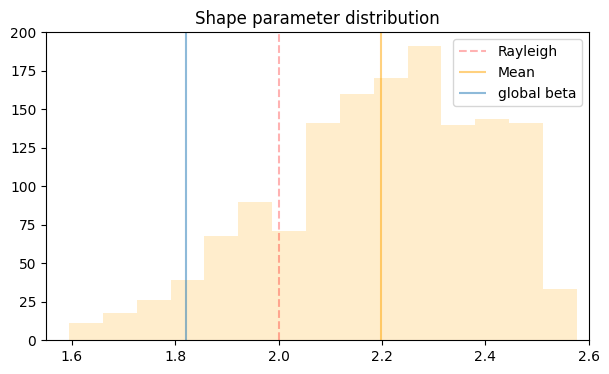

In [63]:
fig, ax = plt.subplots(figsize=(7,4))

ax.set_title('Shape parameter distribution')
ax = plt.hist(ind_betas, bins=15, color='orange', alpha=0.2)
ax = plt.vlines(x = 2, ymin=0, ymax=200, color='red', alpha=0.3, label='Rayleigh', linestyle='dashed')
ax = plt.vlines(x = (sum(ind_betas)/len(ind_betas)), ymin=0, ymax=200, color='orange', alpha=0.5, label='Mean')
ax = plt.vlines(x = 1.81998, ymin=0, ymax=200, alpha=0.5, label='global beta')
plt.xlim(1.55,2.6)
plt.ylim(0,200)
plt.legend()

Parametrization:
Mean =  6.502204277535843 Standard deviation =  1.9267206010425482


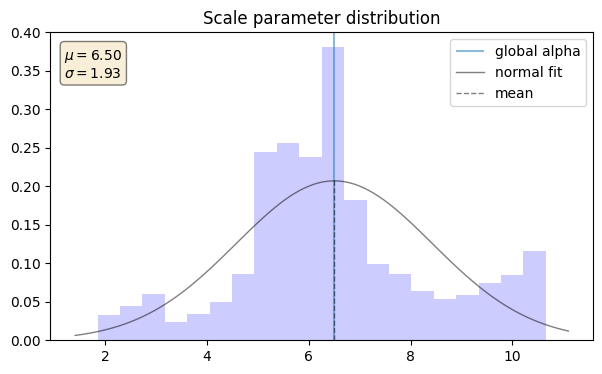

In [64]:
fig, ax2 = plt.subplots(figsize=(7,4))

ax2.set_title('Scale parameter distribution')
ax2 = plt.hist(ind_alphas,  bins=20, color='b', alpha=0.2, density=True)

#ax = plt.vlines(x = (sum(ind_alphas)/len(ind_alphas)), ymin=0, ymax=0.35, color='orange', alpha=0.5, label='Mean')
ax = plt.vlines(x = 6.49391, ymin=0, ymax=0.40, alpha=0.5, label='global alpha')

#parametrizing the alphas
mu, std = ss.norm.fit(ind_alphas)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = ss.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=1, alpha=0.5, label='normal fit')

ax = plt.vlines(x = (sum(ind_alphas)/len(ind_alphas)), ymin=0, ymax=0.21, color='black', alpha=0.5, label='mean', linewidth=1, linestyle='dashed')
# text box
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    #r'$P90=%.2f$' % (mu+std, ),
    r'$\sigma=%.2f$' % (std, )))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
plt.text(1.2, 0.38, textstr, fontsize=10, verticalalignment='top', bbox=props)

plt.ylim(0,0.4)
plt.legend()

print('Parametrization:')
print('Mean = ',mu,'Standard deviation = ',std)

Plotting weibulls for local speeds with global weibull

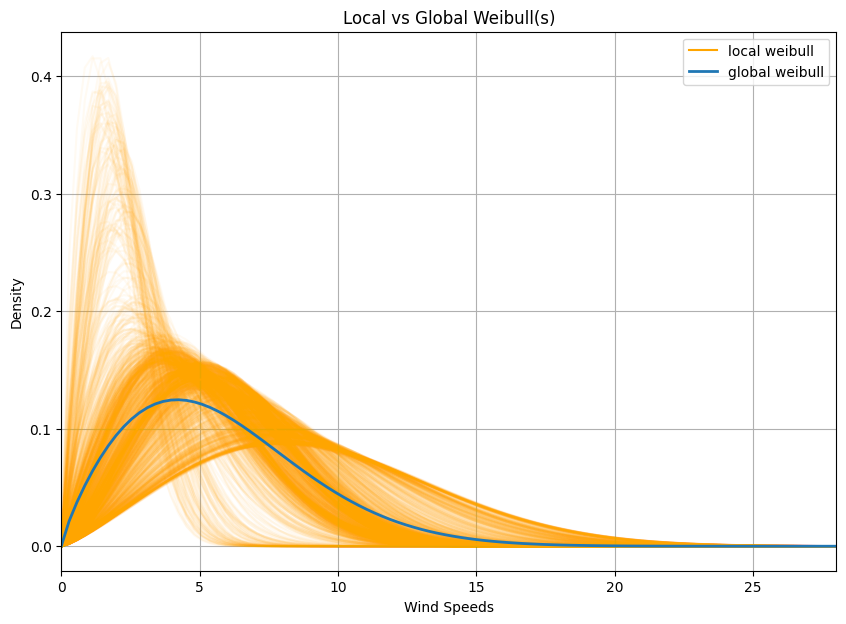

In [268]:
# plotting weibulls
tries = np.linspace(0,28,bin_count)

fig, ax = plt.subplots(figsize=(10,7))

ax.set_title('Local vs Global Weibull(s)')
ax.set_xlim(0,28)
ax.set_xlabel('Wind Speeds')
ax.set_ylabel('Density')

for i in df_params.columns:
    for j in df_params.index:
        
        foo_pdf = [f_weibull(x, df_params[i][j][0], df_params[i][j][1]) for x in tries]
        ax.plot(tries, foo_pdf, color='orange', alpha=0.05)
#replotting an example plot for the label
example_pdf = [f_weibull(x, df_params[50][6][0], df_params[50][6][1]) for x in tries]
ax.plot(tries, example_pdf, color='orange', alpha=1, label='local weibull')

d1, = ax.plot(tries, glob_pdf, linewidth='2', alpha=1, label='global weibull')
ax.grid()
ax.legend()

In [66]:
df_rel_errors = pd.DataFrame(columns=df_params.columns, index=df_params.index)

In [67]:
for i in df_rel_errors.columns:
    for j in df_rel_errors.index:
        
        loc_pdf = [f_weibull(x, df_params[i][j][0], df_params[i][j][1]) for x in tries]
        df_rel_errors[i][j] = [i-j for i,j in zip(loc_pdf, glob_pdf)]

        

In [68]:
df_rel_errors

,47,47.25,47.5,47.75,...,55.25,55.5,55.75,56
6,"[0.0, -0.0014384487761448655, 0.00089049382631...","[0.0, -0.0031901976371816083, -0.0019149051934...","[0.0, -0.00597324492249557, -0.005893435547878...","[0.0, -0.008674175188114157, -0.00994643514537...",...,"[0.0, -0.018665674040959288, -0.03119502987652...","[0.0, -0.018741298700110983, -0.03132948528486...","[0.0, -0.018734931399680105, -0.03131992031026...","[0.0, -0.018967407258896826, -0.03175816568190..."
6.25,"[0.0, 0.0025920234308933546, 0.008005588187739...","[0.0, -0.003374426174199977, -0.00180085209583...","[0.0, -0.0032993715026794386, -0.0012515778851...","[0.0, -0.005605164633961466, -0.00460326110065...",...,"[0.0, -0.018772608137102305, -0.03138400406593...","[0.0, -0.018917090586519976, -0.03165777151923...","[0.0, -0.01891175298095313, -0.031648163252897...","[0.0, -0.019093670680232294, -0.03199369772339..."
6.5,"[0.0, 0.004572996752400155, 0.0118608449984349...","[0.0, -0.0007008635565111561, 0.00304863807993...","[0.0, 0.0012426038916610628, 0.005769547481153...","[0.0, -0.00032767741236550824, 0.0038920528532...",...,"[0.0, -0.018889956600490435, -0.03159104085755...","[0.0, -0.019020501039777524, -0.03184386800372...","[0.0, -0.019032859107884586, -0.03187089638251...","[0.0, -0.019176279254805008, -0.03215263432608..."
6.75,"[0.0, 0.01743628561425482, 0.03156352000000294...","[0.0, 0.0043246328085402505, 0.011280631387843...","[0.0, 0.006704760420506339, 0.0135508703728147...","[0.0, 0.007685307104232375, 0.0150982010837550...",...,"[0.0, -0.01896803075242793, -0.031734940162197...","[0.0, -0.01909693652262979, -0.031987929974852...","[0.0, -0.019132315037926874, -0.03206138064217...","[0.0, -0.01918501992959719, -0.032178416509427..."
7,"[0.0, 0.03508870059791788, 0.05601762367390203...","[0.0, 0.013198399589607241, 0.0254272732498284...","[0.0, 0.017063372566009902, 0.0290519637715676...","[0.0, 0.026937423820337824, 0.0417129783249754...",...,"[0.0, -0.01898374703693693, -0.031772766990569...","[0.0, -0.01902247604398229, -0.031830478925837...","[0.0, -0.019093268937275525, -0.03196761925624...","[0.0, -0.019223908598817903, -0.03222976722407..."
7.25,"[0.0, 0.06548844671876854, 0.09349998498088453...","[0.0, 0.0364812876322672, 0.05732576840878889,...","[0.0, 0.027279016210907867, 0.0441012133861828...","[0.0, 0.04147823477186634, 0.06108162664510633...",...,"[0.0, -0.018968420476105818, -0.03171980565539...","[0.0, -0.018930986950971465, -0.03164939883963...","[0.0, -0.01903810380163714, -0.031853773375969...","[0.0, -0.019210888497032626, -0.03219625517514..."
7.5,"[0.0, 0.07727315168647297, 0.10837082292461452...","[0.0, 0.04839491059000395, 0.07301169844311746...","[0.0, 0.024775557431753945, 0.0439812059688886...","[0.0, 0.035470184827932835, 0.0577106052301192...",...,"[0.0, -0.019016971937642475, -0.03179422102399...","[0.0, -0.01891309089481857, -0.031607247063931...","[0.0, -0.0189573752718994, -0.0317082827660851...","[0.0, -0.019180137391106203, -0.03213633182261..."
7.75,"[0.0, 0.10052998166751072, 0.14366247254892478...","[0.0, 0.06364861078874477, 0.08977069971863642...","[0.0, 0.03974495633984383, 0.06330052375594457...","[0.0, 0.02180746463154439, 0.03960072237748734...",...,"[0.0, -0.01897472504718856, -0.031721285311412...","[0.0, -0.01889712720823589, -0.031558053481890...","[0.0, -0.018905297535695396, -0.03159822534491...","[0.0, -0.019086910432557842, -0.03194124554008..."
8,"[0.0, 0.10838470523583331, 0.15710605162560976...","[0.0, 0.06970813531795156, 0.09739916130198194...","[0.0, 0.050722075604959865, 0.0741382435130861...","[0.0, 0.029386545758935578, 0.0483808897946859...",...,"[0.0, -0.01891699372750772, -0.031608445727986...","[0.0, -0.018665493255118994, -0.03105340522999...","[0.0, -0.01870534505783217, -0.031127285002172...","[0.0, -0.018859897535965637, -0.03143873560185..."
8.25,"[0.0, 0.14114254536119258, 0.2200412956123246,...","[0.0, 0.09008449781647881, 0.13161062196658296...","[0.0, 0.05431682164896805, 0.07

This time we correctly plot the relative errors of individual curves to the global pdf

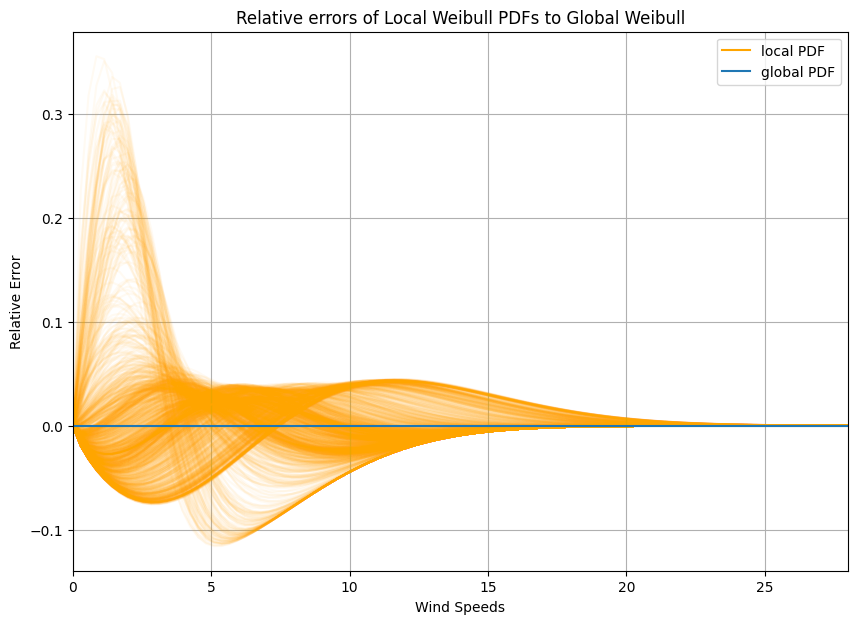

In [201]:
fig, ax = plt.subplots(figsize=(10,7))

ax.set_title('Relative errors of Local Weibull PDFs to Global Weibull')
ax.grid()
ax.set_xlim(0,28)
ax.set_xlabel('Wind Speeds')
ax.set_ylabel('Relative Error')

for i in df_rel_errors.columns:
    for j in df_rel_errors.index:
        ax.plot(tries, df_rel_errors[i][j], color='orange', alpha=0.05)
        
ax.plot(tries, df_rel_errors[50][6], color='orange', label='local PDF')

ax.plot(tries, [0]*100, label = 'global PDF')

ax.legend()

Getting the error for each individual bin:
We want to find the range of the error for each possible wind bracket (in this case 28/100 = 0.28m/s)

In [70]:
df_error_bin = pd.DataFrame(columns=['ranges', 'max', 'min', 'mean', 'std'], index=np.arange(0,100,1))

for n in df_error_bin.index:
    error_bin = []
    for i in df_rel_errors.columns:
        for j in df_rel_errors.index:
            error_bin.append(df_rel_errors[i][j][n])
    df_error_bin['ranges'][n] = error_bin
    df_error_bin['max'][n] = max(error_bin)
    df_error_bin['min'][n] = min(error_bin)
    df_error_bin['mean'][n] = np.mean(error_bin)
    df_error_bin['std'][n] = np.std(error_bin)
    

In [71]:
#df_error_bin.to_csv('df_error_bin.csv')

In [72]:
df_error_bin

,ranges,max,min,mean,std
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,0
1,"[-0.0014384487761448655, 0.0025920234308933546...",0.22525,-0.0196752,-0.00491592,0.0249824
2,"[0.0008904938263194495, 0.008005588187739061, ...",0.318169,-0.0325358,-0.00505776,0.0427203
3,"[0.004137137689831455, 0.013842415785182034, 0...",0.355793,-0.0428959,-0.00383802,0.0566802
4,"[0.0077516843351386755, 0.01958485938142103, 0...",0.352986,-0.0516567,-0.00216105,0.0666377
5,"[0.011431318683805605, 0.024924141463811514, 0...",0.339946,-0.0589382,-0.000511846,0.0724392
6,"[0.014965627686534352, 0.029640961158941714, 0...",0.330176,-0.0648329,0.000845748,0.0742483
7,"[0.0181959178215889, 0.03357497966165621, 0.04...",0.299656,-0.0694007,0.00180155,0.0725722
8,"[0.02100079393607107, 0.0366140042749102, 0.04...",0.251633,-0.072707,0.00235549,0.0681983
9,"[0.023290039602964163, 0.03868884732873698, 0....",0.219562,-0.0748121,0.00257871,0.0620853


### Power Curve for a Wind Turbine

To further investigate the effects of wind speed variations on power output variations, we require the characteristic power curve for a wind turbine. The current analysis is done on a Vestas V100 2.6MW Turbine ([Brochure](http://www.friskvind.se/pdf/orrmosshojden/Bilaga4_V100-2.6MW.pdf)). The power curve is approximated noting power values at integer values speed intervals. 

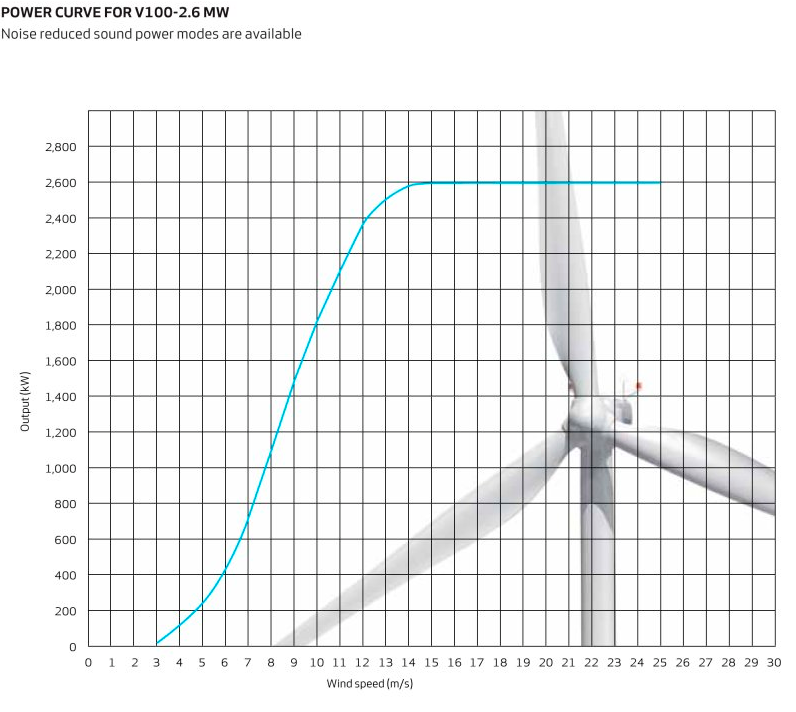

In [73]:
df_powercurve = pd.DataFrame(columns=['windspeed', 'kW'], 
                             #ndex=np.arange(1,)
                            )

In [74]:
df_powercurve['windspeed'] = np.arange(0,28,1)

In [75]:
maxout = [2600]*10
powercurve = [25,125,220,420,710,1080,1475,1825,2100,2370,2510,2585,2598]
powercurve = [25,25, 25] + powercurve + maxout + [0,0]
df_powercurve['kW'] = powercurve

In [76]:
df_powercurve

,windspeed,kW
0,0,25
1,1,25
2,2,25
3,3,25
4,4,125
5,5,220
6,6,420
7,7,710
8,8,1080
9,9,1475


In [270]:
x = df_powercurve['windspeed'] 
y = df_powercurve['kW']

xnew = np.linspace(0, 28, num=100)
ynew = np.interp(xnew, x, y)

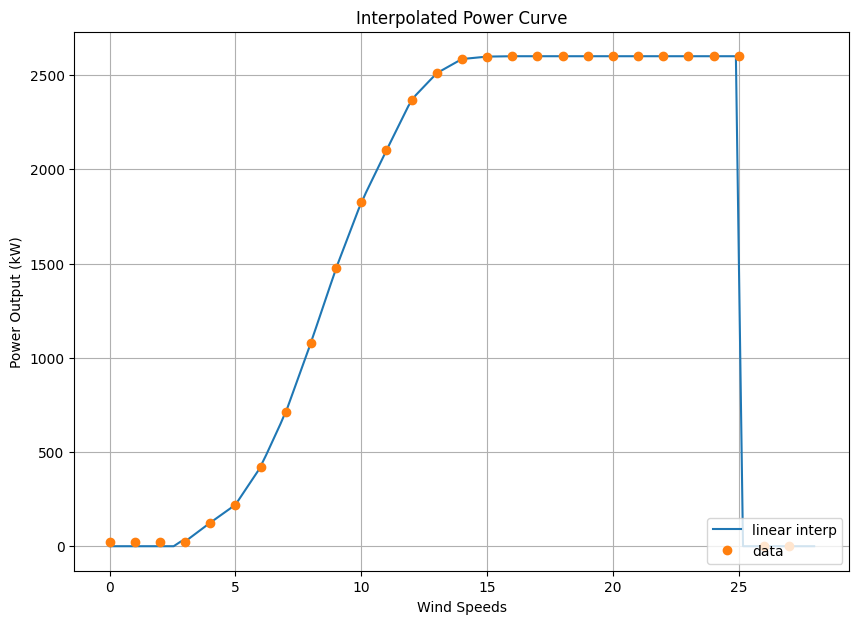

In [280]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(xnew, ynew, '-', label='linear interp')
ax.plot(x, y, 'o', label='data')
ax.legend(loc='lower right')
ax.set_title('Interpolated Power Curve')
ax.set_xlabel('Wind Speeds')
ax.set_ylabel('Power Output (kW)')
ax.grid()

In [272]:
ynew

array([  25.        ,   25.        ,   25.        ,   25.        ,
         25.        ,   25.        ,   25.        ,   25.        ,
         25.        ,   25.        ,   25.        ,   36.11111111,
         64.39393939,   92.67676768,  120.95959596,  148.03030303,
        174.8989899 ,  201.76767677,  238.18181818,  294.74747475,
        351.31313131,  407.87878788,  484.44444444,  566.46464646,
        648.48484848,  736.16161616,  840.80808081,  945.45454545,
       1050.1010101 , 1159.7979798 , 1271.51515152, 1383.23232323,
       1492.67676768, 1591.66666667, 1690.65656566, 1789.64646465,
       1875.        , 1952.77777778, 2030.55555556, 2108.18181818,
       2184.54545455, 2260.90909091, 2337.27272727, 2392.62626263,
       2432.22222222, 2471.81818182, 2510.75757576, 2531.96969697,
       2553.18181818, 2574.39393939, 2586.83838384, 2590.51515152,
       2594.19191919, 2597.86868687, 2598.54545455, 2599.11111111,
       2599.67676768, 2600.        , 2600.        , 2600.     

In [273]:
ynew[0:10] = 0
ynew[89:92] = 0


In [274]:
len(ynew)

100

In [221]:
df_foo = pd.DataFrame()

df_foo['powercurve'] = ynew
df_foo['pdf'] = glob_pdf
df_foo.index = np.linspace(0,28,bin_count) 

In [222]:
df_foo

,powercurve,pdf
0,0,0
0.282828,0,0.0213845
0.565657,0,0.0374351
0.848485,0,0.0515339
1.13131,0,0.0641482
1.41414,0,0.0754409
1.69697,0,0.0854817
1.9798,0,0.0943063
2.26263,0,0.101939
2.54545,0,0.108405


In [84]:
global_power = sum([i*j for i,j in zip(glob_pdf,ynew)])

In [85]:
df_local_power = pd.DataFrame(columns=lats_list, index=lons_list)
tries = np.linspace(0,28,bin_count)

for i in df_local_power.columns:
    for j in df_local_power.index:
        foo_pdf = [f_weibull(x, df_params[i][j][0], df_params[i][j][1]) for x in tries]
        df_local_power[i][j] = sum([a*b for a,b in zip(ynew, foo_pdf)])

In [86]:
df_local_power

,47,47.25,47.5,47.75,...,55.25,55.5,55.75,56
6,1543.01,1608.32,1577.21,1536.99,...,4898.59,4900.97,4904.08,4950.31
6.25,1284.16,1524.05,1432.18,1407.88,...,4899.31,4930.45,4930.37,4964.82
6.5,1130.56,1334.85,1340.39,1283.18,...,4895.15,4929.97,4939.39,4981.78
6.75,871.944,1160.89,1286.67,1252.72,...,4901.78,4940.44,4958.94,5002.67
7,694.117,925.482,1039.04,975.678,...,4920.66,4895.47,4912.08,4959.06
7.25,539.186,708.032,841.479,798.177,...,4870.11,4864.77,4884.95,4938.48
7.5,466.626,613.161,676.887,639.089,...,4842.05,4845.38,4887.01,4931.63
7.75,273.942,592.818,613.593,711.6,...,4850.15,4805.45,4855.29,4881.37
8,219.592,549.866,664.847,739.912,...,4833.85,4640.65,4644.61,4704.43
8.25,80.3202,294.663,708.315,807.626,...,4521.95,4309.27,4275.18,4351.86


In [87]:
#df_local_power.values.flatten() #getting all the values for histogram

In [161]:
power_mean = np.mean(df_local_power.values.flatten())
power_std = np.std(df_local_power.values.flatten())

Text(0.5, 1.0, '10 bins')

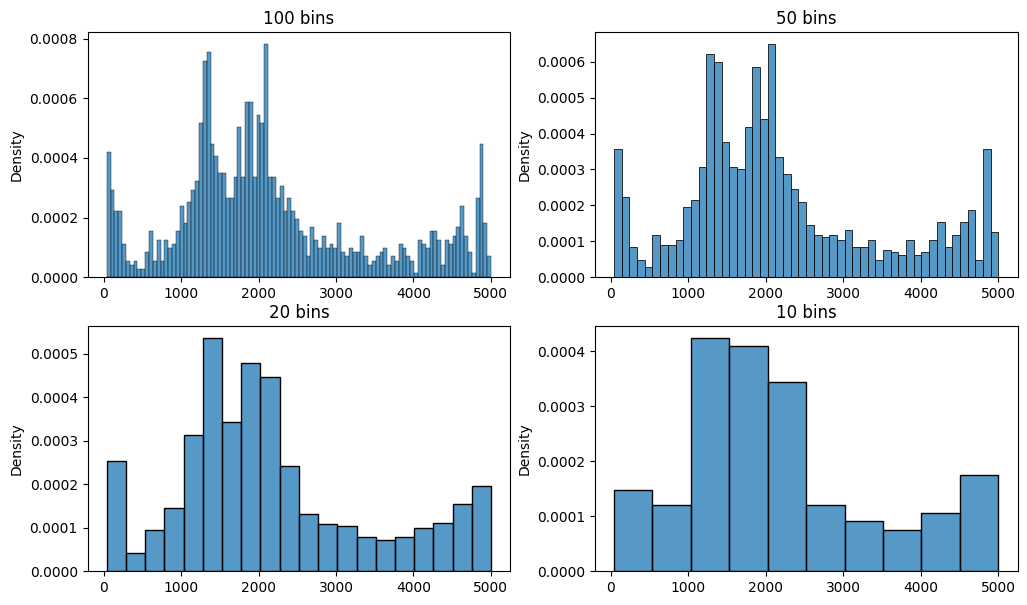

In [98]:
fig2, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,7))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.histplot(df_local_power.values.flatten(), bins=100, stat='density', ax=ax1)
ax1.set_title('100 bins')
sns.histplot(df_local_power.values.flatten(), bins=50, stat='density', ax=ax2)
ax2.set_title('50 bins')
sns.histplot(df_local_power.values.flatten(), bins=20, stat='density', ax=ax3)
ax3.set_title('20 bins')
sns.histplot(df_local_power.values.flatten(), bins=10, stat='density', ax=ax4)
ax4.set_title('10 bins')
#ax1.plot(glob_pdf)

#sns.histplot(df_local_power.values.flatten(), bins=50, stat='density')

Clearly somewhere between 50 and 20 bins seems like an ideal bin amount

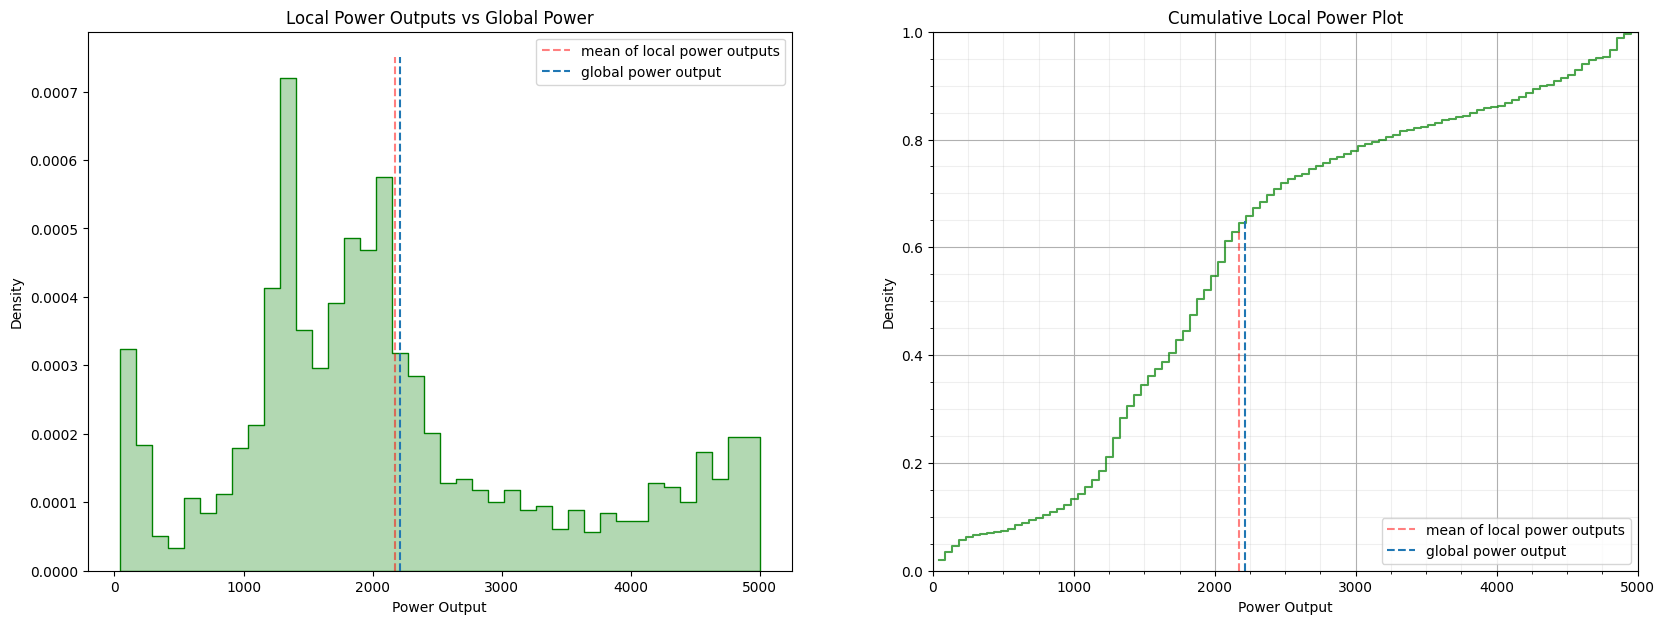

In [224]:
fig, ax = plt.subplots(1,2, figsize=(20,7))

ax[0].set_title('Local Power Outputs vs Global Power')

#w, b = np.histogram(df_local_power.values.flatten(), 40)
sns.histplot(df_local_power.values.flatten(), bins=40, stat='density', 
             ax=ax[0], color='g', alpha=0.3, element='step')
ax[0].vlines(x=power_mean, ymin=0, ymax=0.00075, 
          label='mean of local power outputs', lw=1.5, color='red', alpha=0.5,linestyle='dashed')
ax[0].vlines(x=global_power, ymin=0, ymax=0.00075, 
          label='global power output', lw=1.5, 
          #color='orange', 
          alpha=1,linestyle='dashed')
ax[0].set_xlabel('Power Output')
ax[0].legend()

##############################

ax[1].set_title('Cumulative Local Power Plot')

sns.histplot(df_local_power.values.flatten(), bins=100, stat='density', 
             ax=ax[1], color='g', alpha=0.7, element='step',
            fill=False, cumulative=True)
ax[1].vlines(power_mean, ymin=0, ymax=0.63, 
          label='mean of local power outputs', lw=1.5, color='red', alpha=0.5,linestyle='dashed')
ax[1].vlines(x=global_power, ymin=0, ymax=0.65, 
          label='global power output', lw=1.5, 
          #color='orange', 
          alpha=1,linestyle='dashed')
ax[1].set_xlabel('Power Output')

ax[1].set_xlim(0,5000)
ax[1].set_ylim(0,1.0)

ax[1].set_yticks(np.arange(0,1.2,0.2), major=True)
ax[1].set_yticks(np.arange(0,1,0.05), minor=True)
ax[1].set_xticks(np.arange(0,6000,1000), major=True)
ax[1].set_xticks(np.arange(0,5000,250), minor=True)

ax[1].grid(which='minor', alpha=0.2)
ax[1].grid(which='major', alpha=1)

ax[1].legend(loc='lower right')

thus 65% of the wind speed locations are 

In [164]:
df_local_power_curve = pd.DataFrame(columns=lats_list, index=lons_list)

for i in df_local_power_curve.columns:
    for j in df_local_power_curve.index:
        foo_pdf = [f_weibull(x, df_params[i][j][0], df_params[i][j][1]) for x in tries]
        df_local_power_curve[i][j] = [a*b for a,b in zip(ynew, foo_pdf)]

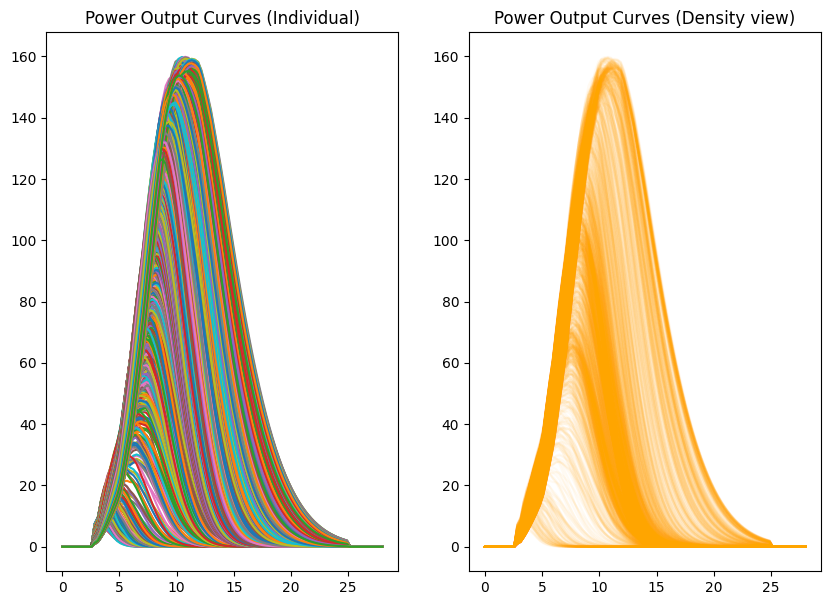

In [172]:
fix, ax = plt.subplots(1,2,figsize=(10,7))

sns.histplot(df_local_power.values.flatten(), bins=40, stat='density', 
             ax=ax[0], color='g', alpha=0.3, element='step')
for i in df_local_power_curve.columns:
    for j in df_local_power_curve.index:
        ax[0].plot(tries, df_local_power_curve[i][j])
        
ax[1].set_title('Power Output Curves (Density view)')
for i in df_local_power_curve.columns:
    for j in df_local_power_curve.index:
        ax[1].plot(tries, df_local_power_curve[i][j], color='orange', alpha=0.05)

Parametrization:
Mean =  2171.87525987526 Standard deviation =  1260.0015365759634


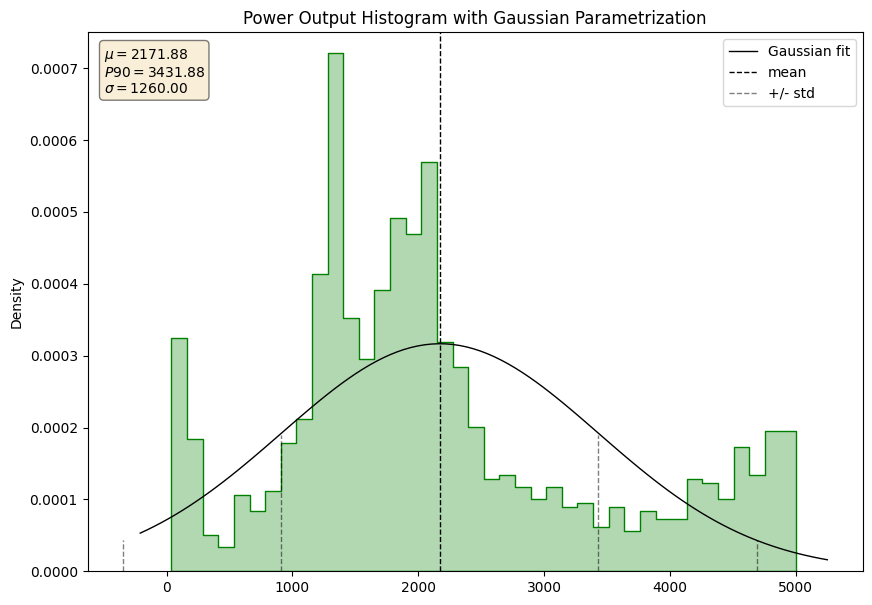

In [248]:
fig, ax = plt.subplots(figsize=(10,7))


foo_list = [int(i) for i in foo_list]

ax.set_title('Power Output Histogram with Gaussian Parametrization')
sns.histplot(foo_list, bins=40, stat='density', 
             ax=ax, color='g', alpha=0.3, element='step')

#ax = plt.vlines(x = (sum(ind_alphas)/len(ind_alphas)), ymin=0, ymax=0.35, color='orange', alpha=0.5, label='Mean')
#ax = plt.vlines(x = 6.49391, ymin=0, ymax=0.40, alpha=0.5, label='global alpha')

#parametrizing the power outputs
mu, std = ss.norm.fit(foo_list)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = ss.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=1, alpha=1, label='Gaussian fit')

ax.vlines(x = mu, ymin=0, ymax=0.00075, color='black', alpha=1, label='mean', linewidth=1, linestyle='dashed')
ax.vlines(x = mu+std, ymin=0, ymax=0.00019, color='black', alpha=0.5, label='+/- std', linewidth=1, linestyle='dashed')
ax.vlines(x = mu-std, ymin=0, ymax=0.00019, color='black', alpha=0.5, linewidth=1, linestyle='dashed')
ax.vlines(x = mu+2*std, ymin=0, ymax=0.000043, color='black', alpha=0.5, linewidth=1, linestyle='dashed')
ax.vlines(x = mu-2*std, ymin=0, ymax=0.000043, color='black', alpha=0.5, linewidth=1, linestyle='dashed')
# text box
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$P90=%.2f$' % (mu+std, ),
    r'$\sigma=%.2f$' % (std, )))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
plt.text(-500, 0.00073, textstr, fontsize=10, verticalalignment='top', bbox=props)

ax.set_ylim(0,0.00075)
plt.legend()

print('Parametrization:')
print('Mean = ',mu,'Standard deviation = ',std)

Thus:
    - mean: 2171
    - standard deviation

In [178]:
mu, std = ss.norm.fit(foo_list)